In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport

%matplotlib inline

# Read data

In [2]:
data_dir = "../data"
geo_path = os.path.join(data_dir, "geo.csv")
sales_path = os.path.join(data_dir, "product_sales.csv")

In [3]:
df_geo = pd.read_csv(geo_path, sep=",")
df_sales = pd.read_csv(sales_path, sep=",")

In [4]:
df_geo.head()

,country,s_zipcode,e_zipcode,city
0,B,63700000,63740000,B1
1,B,57968000,57980000,B1
2,B,46966970,46970000,B1
3,B,44600000,44640000,B1
4,B,49670000,49700000,B1


In [5]:
df_sales.head()

,country,product_id,date,zipcode,sales
0,M,bded4d22-a25e-4b42-b9d6-41d3b1a5f71b,2024-07-21,85890.0,3.0
1,M,0310455e-2ec8-4e02-8a12-b59424678ff2,2024-08-06,97267.0,9999
2,B,c5b9d75d-86bc-4e87-87c4-1d751096d21a,2024-07-10,13212117.0,1.0
3,B,b7a56357-a4a2-4bdf-94be-cb82636bd7ec,2024-07-12,88340455.0,1.0
4,B,2aac125e-5623-4206-8161-881a28d7826c,2024-07-19,99840000.0,9999


In [6]:
df_geo.dtypes

country      object
s_zipcode     int64
e_zipcode     int64
city         object
dtype: object

In [7]:
df_sales.dtypes

country        object
product_id     object
date           object
zipcode       float64
sales          object
dtype: object

# Preliminar analysis

The geo dataset includes two countries, Mexico and Brazil, with most cities being from Mexico. It has no missing values or duplicates and does not appear to have any data issues. The sales dataset spans from June 1, 2024, to August 7, 2024, covering 68 days with a total of 227,355 rows. It has 0.1% of rows with missing values in the sales column and 26.4% duplicate rows. There are 990 distinct products, and the sales data comes from five countries: Brazil, Mexico, Argentina, Chile, and Colombia, listed in descending order of transaction volume. The sales column is currently of type object instead of float due to the presence of the value "xfffx" in some rows. The high number of duplicates arises because each row represents a transaction, and the dataset has not been aggregated by (zipcode, product_id, date).

In [8]:
geo_profile = ProfileReport(df_geo, title="Geo Profiling Report")

In [9]:
geo_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
sales_profile = ProfileReport(df_sales, title="Sales Profiling Report")

In [11]:
sales_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Select sales that intersect with geo dataset

I am assuming that all sales are national; without this assumption, a single zipcode could correspond to multiple country-city pairs. Since the geo dataset includes zipcode ranges for cities in Brazil and Mexico, sales data from Argentina, Chile, and Colombia will be discarded. Consequently, any sales that do not intersect with the geo dataset will also be discarded. It is important to note that there are 7,920 possible city-product combinations, of which 2,951 are present in the sales data, representing approximately 37.26 percent.

In [12]:
products = df_sales.product_id.unique()
cities = df_geo.city.unique()
df_products = pd.DataFrame({"product_id": products})
df_cities = pd.DataFrame({"city": cities})
df_cities_products = df_cities.merge(df_products, how="cross")
df_cities_products.head()

,city,product_id
0,B1,bded4d22-a25e-4b42-b9d6-41d3b1a5f71b
1,B1,0310455e-2ec8-4e02-8a12-b59424678ff2
2,B1,c5b9d75d-86bc-4e87-87c4-1d751096d21a
3,B1,b7a56357-a4a2-4bdf-94be-cb82636bd7ec
4,B1,2aac125e-5623-4206-8161-881a28d7826c


In [13]:
df_geo = df_geo.sort_values(["country", "s_zipcode"]).reset_index(drop=True)
country_zipcodes = {}
for country, group in df_geo.groupby('country'):
    country_zipcodes[country] = list(group[['s_zipcode', 'e_zipcode', 'city']].itertuples(index=False, name=None))

def find_city_by_zipcode(country_zipcodes: dict, country: str, zipcode: str):
    for (start_zipcode, end_zipcode, city) in country_zipcodes.get(country, []):
        if start_zipcode <= zipcode and end_zipcode > zipcode:
            return city
    return None

In [14]:
df_sales["city"] = df_sales.apply(lambda x: find_city_by_zipcode(country_zipcodes, x["country"], x["zipcode"]), axis=1)

In [15]:
count_sales_with_no_city = len(df_sales[df_sales["city"].isnull()])
percentage_count_sales_with_no_city = round(100*count_sales_with_no_city/len(df_sales), 2)
count_sales_with_no_city, percentage_count_sales_with_no_city

(12241, 5.38)

In [16]:
df_sales = df_sales[~df_sales["city"].isnull()].reset_index(drop=True)

In [17]:
len(df_sales)

215114

In [18]:
count_cities_products = len(df_cities_products)
count_cities_products_in_sales = len(df_sales[["city", "product_id"]].drop_duplicates())
count_cities_products, count_cities_products_in_sales , round(100*count_cities_products_in_sales/count_cities_products, 2)

(7920, 2951, 37.26)

# Sales column casting

I will consider all values that cannot be converted to a float as missing values, such as "xfffx," which appears in 0.12% of the rows and does not exhibit any discernible pattern. However, I will not eliminate higher values like 9999, as it seems the dataset was already truncated at this number or is the maximum value that the information system allows, which could explain why 17.52% of the rows contain this value. It is important to note that 0.02% of the rows have missing values. Additionally, the highest value of 9999 does not show a clear pattern when analyzed by weekday or city. This value is present in 25.49% of zip codes, 92.15% of products, and 70.99% of city-product combinations.

In [19]:
df_sales_count_unique_values  = pd.DataFrame({"count": df_sales.sales.astype(str).value_counts()})
df_sales_count_unique_values["percentage"] = 100*(df_sales_count_unique_values["count"]/df_sales_count_unique_values["count"].sum()).round(4)
df_sales_count_unique_values.sort_values("percentage", ascending=False)

,count,percentage
1.0,154228,71.70
9999,37693,17.52
2.0,13966,6.49
3.0,4390,2.04
4.0,1998,0.93
5.0,850,0.40
6.0,688,0.32
10.0,301,0.14
xfffx,263,0.12
8.0,172,0.08


In [20]:
def cast_to_float(sale):
    try:
        return float(sale)
    except:
        return np.nan

In [21]:
df_sales["sales"] = df_sales["sales"].apply(lambda x: cast_to_float(x))
df_sales["date"] = pd.to_datetime(df_sales["date"])
df_sales["weekday"] = df_sales["date"].apply(lambda x: x.weekday())

In [22]:
df_sales.groupby("weekday").agg({"sales": "sum"})

,sales
weekday,
0,61250286.0
1,62801323.0
2,60329991.0
3,54527985.0
4,45823470.0
5,45001038.0
6,47382979.0


#### 9999 presence by weekday

In [23]:
df_agg = df_sales.groupby("weekday").agg({"weekday": "count"})
df_agg = df_agg.join(df_sales[df_sales["sales"] == 9999].groupby("weekday").agg({"sales": "count"}))
df_agg["%"] = df_agg["sales"]/df_agg["weekday"]
df_agg

,weekday,sales,%
weekday,,,
0,34628,6122,0.176793
1,35719,6277,0.175733
2,34379,6030,0.175398
3,31133,5450,0.175055
4,26599,4580,0.172187
5,25322,4498,0.177632
6,27334,4736,0.173264


#### 9999 presence by city

In [24]:
df_agg = df_sales.groupby("city").agg({"city": "count"})
df_agg = df_agg.join(df_sales[df_sales["sales"] == 9999].groupby("city").agg({"sales": "count"}), how="left")
df_agg["%"] = df_agg["sales"]/df_agg["city"]
df_agg

,city,sales,%
city,,,
B1,17055,2940,0.172383
B2,15941,2771,0.173828
B3,115029,20096,0.174704
M1,2967,526,0.177283
M2,14229,2537,0.178298
M3,35870,6438,0.179481
M4,10532,1766,0.167679
M5,3491,619,0.177313


#### 9999 presence by zipcode

In [25]:
df_agg = df_sales.groupby("zipcode").agg({"zipcode": "count"})
df_agg = df_agg.join(df_sales[df_sales["sales"] == 9999].groupby("zipcode").agg({"sales": "count"})).fillna(0)
df_agg["%"] = df_agg["sales"]/df_agg["zipcode"]
print(len(df_agg[df_agg["sales"] > 0.0]))
df_agg

18121


,zipcode,sales,%
zipcode,,,
1000.0,6,0.0,0.000000
1010.0,1,1.0,1.000000
1020.0,10,1.0,0.100000
1030.0,2,1.0,0.500000
1050.0,3,0.0,0.000000
...,...,...,...
99952000.0,5,5.0,1.000000
99960000.0,3,1.0,0.333333
99965000.0,1,1.0,1.000000


### 9999 presence by product_id

In [26]:
df_agg = df_sales.groupby("product_id").agg({"product_id": "count"})
df_agg = df_agg.join(df_sales[df_sales["sales"] == 9999].groupby("product_id").agg({"sales": "count"})).fillna(0)
df_agg["%"] = df_agg["sales"]/df_agg["product_id"]
print(len(df_agg[df_agg["sales"] > 0.0]))
df_agg

833


,product_id,sales,%
product_id,,,
0067adfb-25e3-421c-aa04-8123762cccce,16,0.0,0.000000
00afde38-77a7-410e-8f94-9d1110a44693,21,3.0,0.142857
00dac0d3-3b8f-4d7f-919a-bfb852e11148,86,10.0,0.116279
00fcdebe-63de-4e41-bcbe-1d13017ae42c,23,1.0,0.043478
010facf4-08f0-4b25-9eef-2522a8caed4b,11,0.0,0.000000
...,...,...,...
fdfae901-61c9-485a-808e-24b8ad5b2ac2,3,1.0,0.333333
fe2dca78-fa59-43f3-a164-e0a322bb67a0,17,0.0,0.000000
fe315793-9956-441b-addc-68b76fa7df06,242,46.0,0.190083


In [27]:
df_agg = df_sales.groupby(["city", "product_id"]).agg({"sales": "count"})
df_agg = df_agg.join(df_sales[df_sales["sales"] == 9999].groupby(["city", "product_id"]).agg({"sales": "count"}), lsuffix="_total").fillna(0)
df_agg["%"] = df_agg["sales"]/df_agg["sales_total"]
print(len(df_agg[df_agg["sales"] > 0.0]))
df_agg

2095


sales_total  sales         %
city product_id                                                        
B1   00afde38-77a7-410e-8f94-9d1110a44693            1    0.0  0.000000
     00dac0d3-3b8f-4d7f-919a-bfb852e11148           10    0.0  0.000000
     010facf4-08f0-4b25-9eef-2522a8caed4b            8    0.0  0.000000
     015ad371-f82f-4eba-ab3a-dc4c77262d23            2    0.0  0.000000
     01ceb2f7-f178-4a23-b470-20755a3be241            8    0.0  0.000000
...                                                ...    ...       ...
M5   f96e2221-047b-4a47-94d5-f1c41e259b06            1    1.0  1.000000
     f9c7a0df-a41e-4c8a-b357-7c1aca558a41           22    4.0  0.181818
     fc5e84a1-ab31-4367-b55c-7c782bac2a9e            8    2.0  0.250000
     fd3a6821-4fd5-4a09-98ba-d38993ce100a            2    0.0  0.000000
     fd5e34b7-b42d-41ea-a3f8-dd4b1824589c            6    0.0  0.000000

[2951 rows x 3 columns]

# Group by sales by city, product and date

Aggregate sales by city, product and date, each combination city products is considered as a time series. Null sales are considered as zero, not sale happen. The missing dates between the first not null sale and last date sale in the dataset are filled by zero per each time serie.

In [28]:
df_sales = df_sales.fillna(0.0).groupby(["city", "product_id", "date"]).agg({"sales": "sum"}).reset_index()

In [29]:
last_sales_date = df_sales.date.max()
def add_missing_dates(df_timeserie: pd.DataFrame):
    date_range = pd.date_range(start=df_timeserie['date'].min(), end=last_sales_date)
    timeserie = df_timeserie.set_index('date')["sales"].reindex(date_range).fillna(0.0)
    first_row = df_timeserie.iloc[0].to_dict()
    city = first_row["city"]
    product_id = first_row["product_id"]
    df_timeserie = pd.DataFrame(
        {
            "city": city,
            "product_id": product_id,
            "date": date_range,
            "sales": timeserie.values
         
        }
    )
    return df_timeserie

In [30]:
df_sales = df_sales.groupby(["city", "product_id"]).apply(add_missing_dates).reset_index(drop=True)
df_sales.head()

,city,product_id,date,sales
0,B1,00afde38-77a7-410e-8f94-9d1110a44693,2024-06-07,1.0
1,B1,00afde38-77a7-410e-8f94-9d1110a44693,2024-06-08,0.0
2,B1,00afde38-77a7-410e-8f94-9d1110a44693,2024-06-09,0.0
3,B1,00afde38-77a7-410e-8f94-9d1110a44693,2024-06-10,0.0
4,B1,00afde38-77a7-410e-8f94-9d1110a44693,2024-06-11,0.0


# Time series categorizing

To effectively categorize time series data, I will employ the Average Demand Interval (ADI) and the Coefficient of Variation squared (CV^2) following the Syntetos/Boylan classification method. This approach transforms a time series into one of four distinct categories: "smooth", "erratic", "intermittent" or "lumpy". Specifically, a time series is deemed "intermittent" if its ADI is greater than or equal to a threshold of 1.32, and "erratic" if its CV^2 is greater than or equal to a threshold of 0.49. If both conditions are met, the series is classified as "lumpy." Conversely, if neither condition is satisfied, the series is categorized as "smooth." This classification system provides a structured way to analyze and interpret time series data, facilitating more accurate forecasting.

In analyzing the distribution of time series categories, it is evident that the majority fall into the "lumpy" category, accounting for 63.50% of the data. This is followed by "intermittent" series, which make up 29.48%, indicating a significant portion of the data also exhibits sporadic demand patterns. "Erratic" series, with highly variable demand, represent 6.64% of the time series, while "smooth" series, characterized by consistent demand, constitute the smallest category at 0.37%, although half of it is smooth because dont have enough data. This distribution highlights the prevalence of irregular demand patterns in time series data, showing the importance of employing specialized forecasting methods to accurately predict future demand.

In [31]:
def get_adicv2(df_timeserie: pd.DataFrame, adi_threshold: float = 1.32, cv2_threshold: float = 0.49):
    y = df_timeserie["sales"].values
    y_nonzero = y[y > 0]
    adi = len(y)/len(y_nonzero)
    cv2 = (y_nonzero.std()/y_nonzero.mean())**2

    intermitent = (adi > adi_threshold)
    erratic = (cv2 > cv2_threshold)
    class_type = "smooth"
    if intermitent and erratic:
        class_type = "lumpy"
    elif intermitent:
        class_type = "intermittent"
    elif erratic:
        class_type = "erratic"
    df_adicv2 = pd.DataFrame([{"adi": adi, "cv2": cv2, "class": class_type, "count": len(y)}])
    return df_adicv2

In [32]:
adi_threshold = 1.32
cv2_threshold = 0.49

In [33]:
df_adicv2 = df_sales.groupby(["city", "product_id"]).apply(lambda x: get_adicv2(x, adi_threshold, cv2_threshold)).reset_index(level=2, drop=True).reset_index()
df_adicv2.head()

,city,product_id,adi,cv2,class,count
0,B1,00afde38-77a7-410e-8f94-9d1110a44693,62.0,0.000000,intermittent,62
1,B1,00dac0d3-3b8f-4d7f-919a-bfb852e11148,10.6,0.100000,intermittent,53
2,B1,010facf4-08f0-4b25-9eef-2522a8caed4b,8.2,0.479592,intermittent,41
3,B1,015ad371-f82f-4eba-ab3a-dc4c77262d23,63.0,0.000000,intermittent,63
4,B1,01ceb2f7-f178-4a23-b470-20755a3be241,7.0,0.254438,intermittent,28


In [34]:
df_agg = df_adicv2.groupby("class").agg({"product_id": "count"})
df_agg["%"] = 100*(df_agg["product_id"]/df_agg["product_id"].sum()).round(4)
df_agg

,product_id,%
class,,
erratic,196,6.64
intermittent,870,29.48
lumpy,1874,63.50
smooth,11,0.37


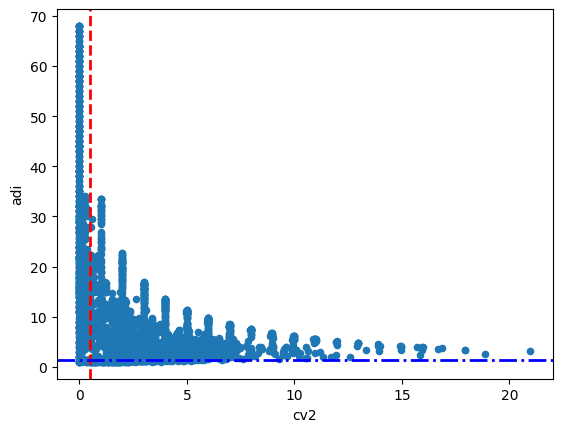

In [35]:
df_adicv2.plot.scatter(x="cv2", y="adi")
plt.axvline(x=cv2_threshold, color='r', linestyle='--', linewidth=2, label='y=4')
plt.axhline(y=adi_threshold, color='b', linestyle='-.', linewidth=2, label='x=3')

In [36]:
def plot_timeseries(grouped: pd.core.groupby.generic.DataFrameGroupBy):
    num_groups = len(grouped)
    num_cols = 3
    num_rows = (num_groups + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 5), constrained_layout=True)
    axes = axes.flatten()
    for i, ((city, product_id), group) in enumerate(grouped):
        ax = axes[i]
        ax.plot(group['date'], group['sales'], marker='o')
        ax.set_title(f'City: {city}, Product ID: {product_id}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Sales')
        ax.grid(True)
        ax.tick_params(axis='x', rotation=45)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.show()


In [37]:
df = pd.merge(df_sales, df_adicv2, how="inner", on=["city", "product_id"])

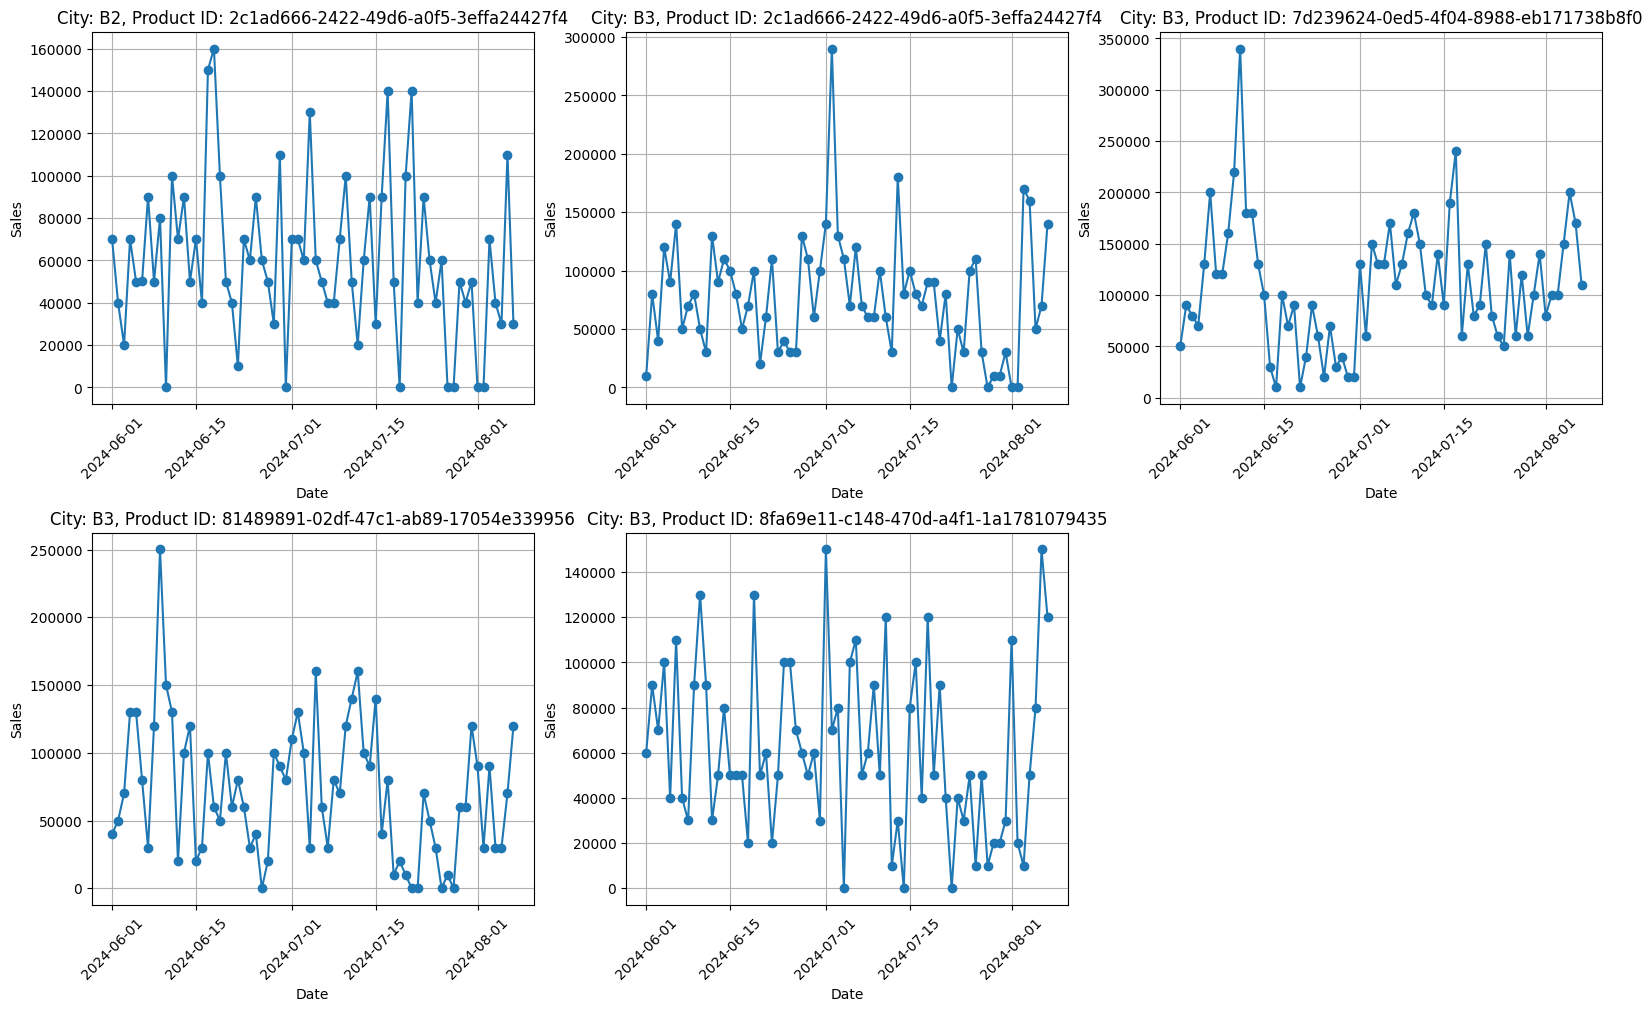

In [38]:
grouped = df[(df["class"] == "smooth") & (df["count"] >= 7)].groupby(["city", "product_id"])
plot_timeseries(grouped)

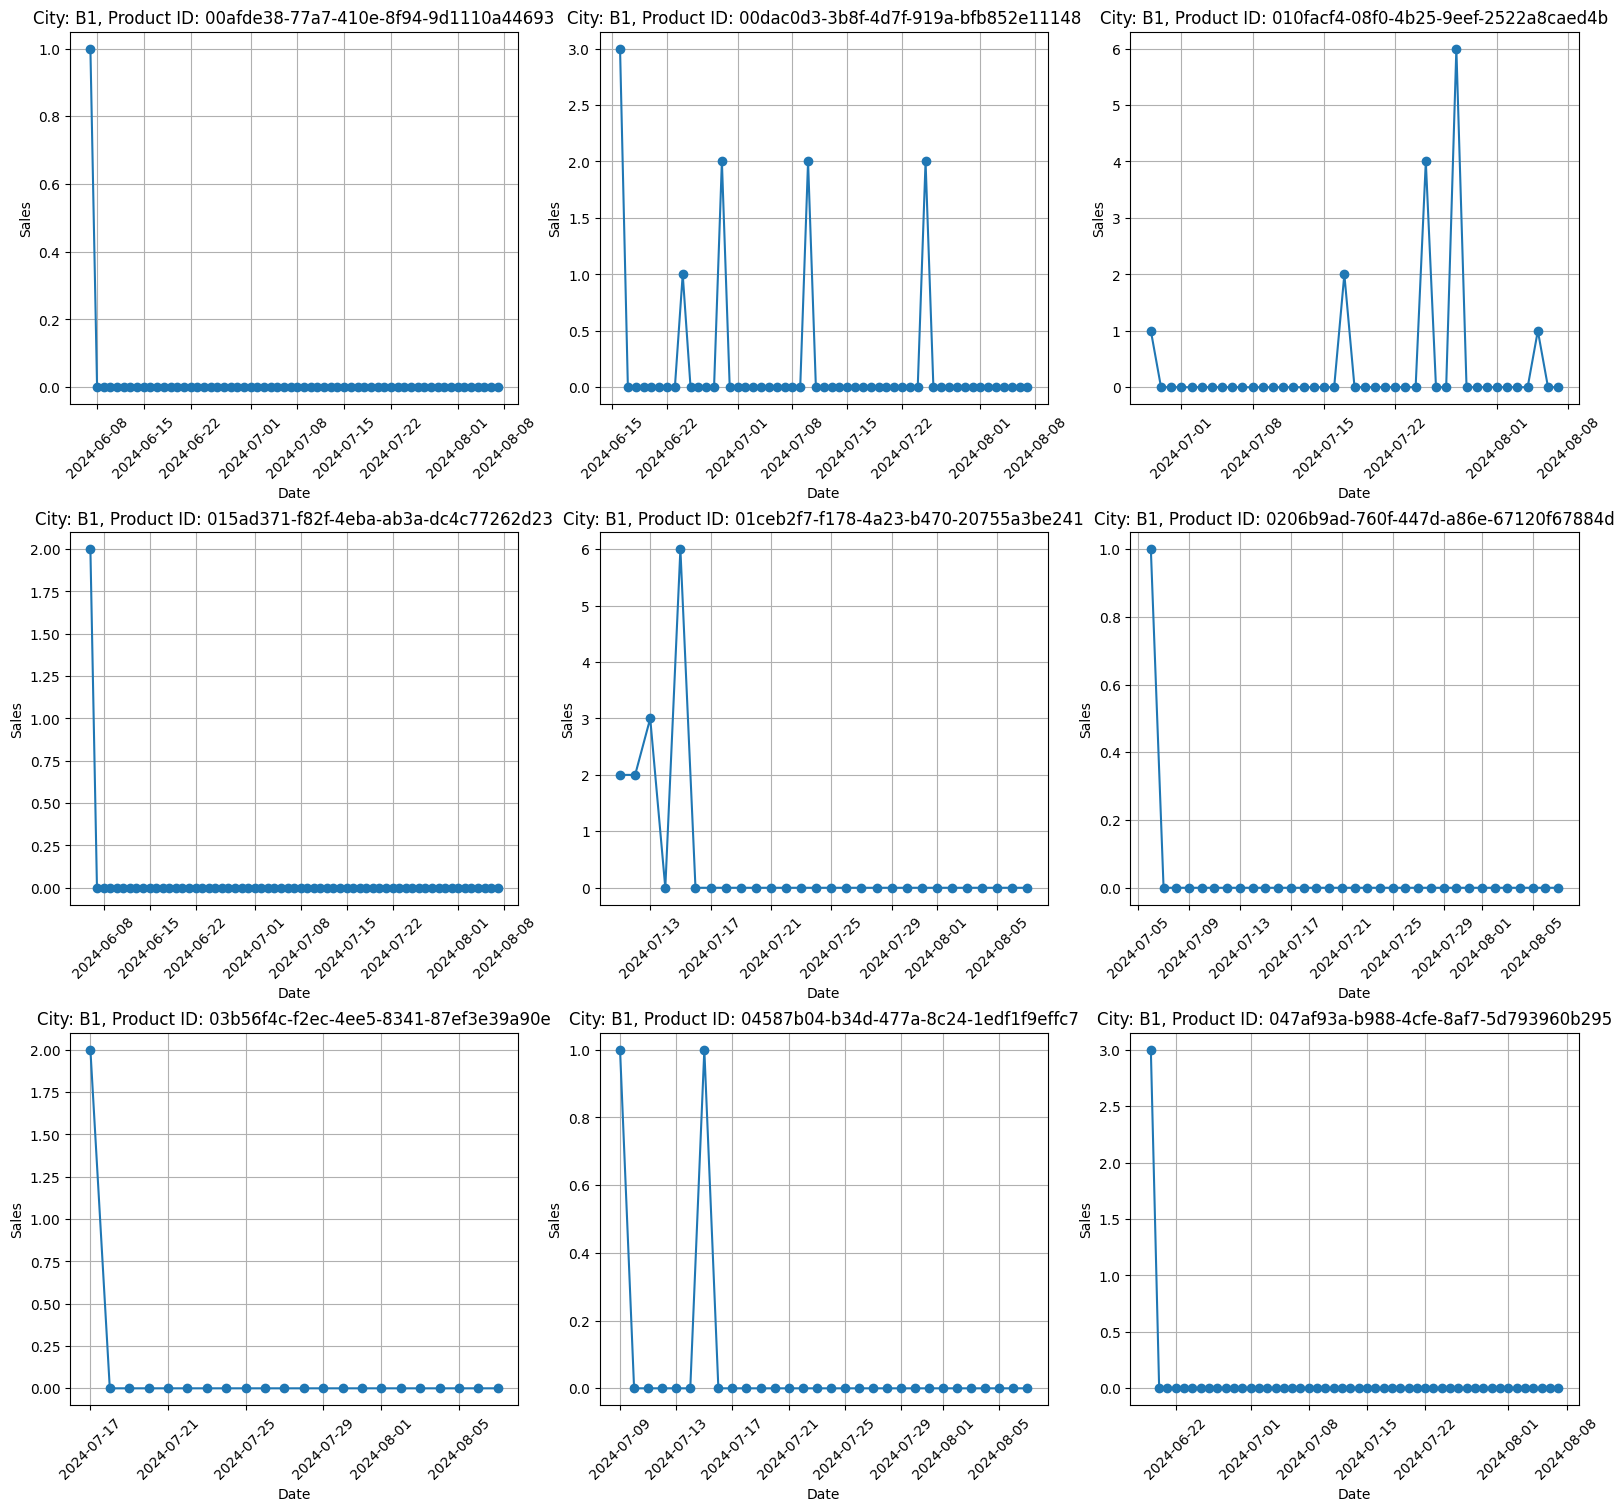

In [39]:
sample_size = 9
df_intermittent = df[(df["class"] == "intermittent") & (df["count"] >= 7)]
df_intermittent_sample = pd.merge(
    df_intermittent[["city", "product_id"]].drop_duplicates().iloc[0:9],
    df_intermittent,
    how="inner",
    on=["city", "product_id"]
)

grouped = df_intermittent_sample.groupby(["city", "product_id"])
plot_timeseries(grouped)

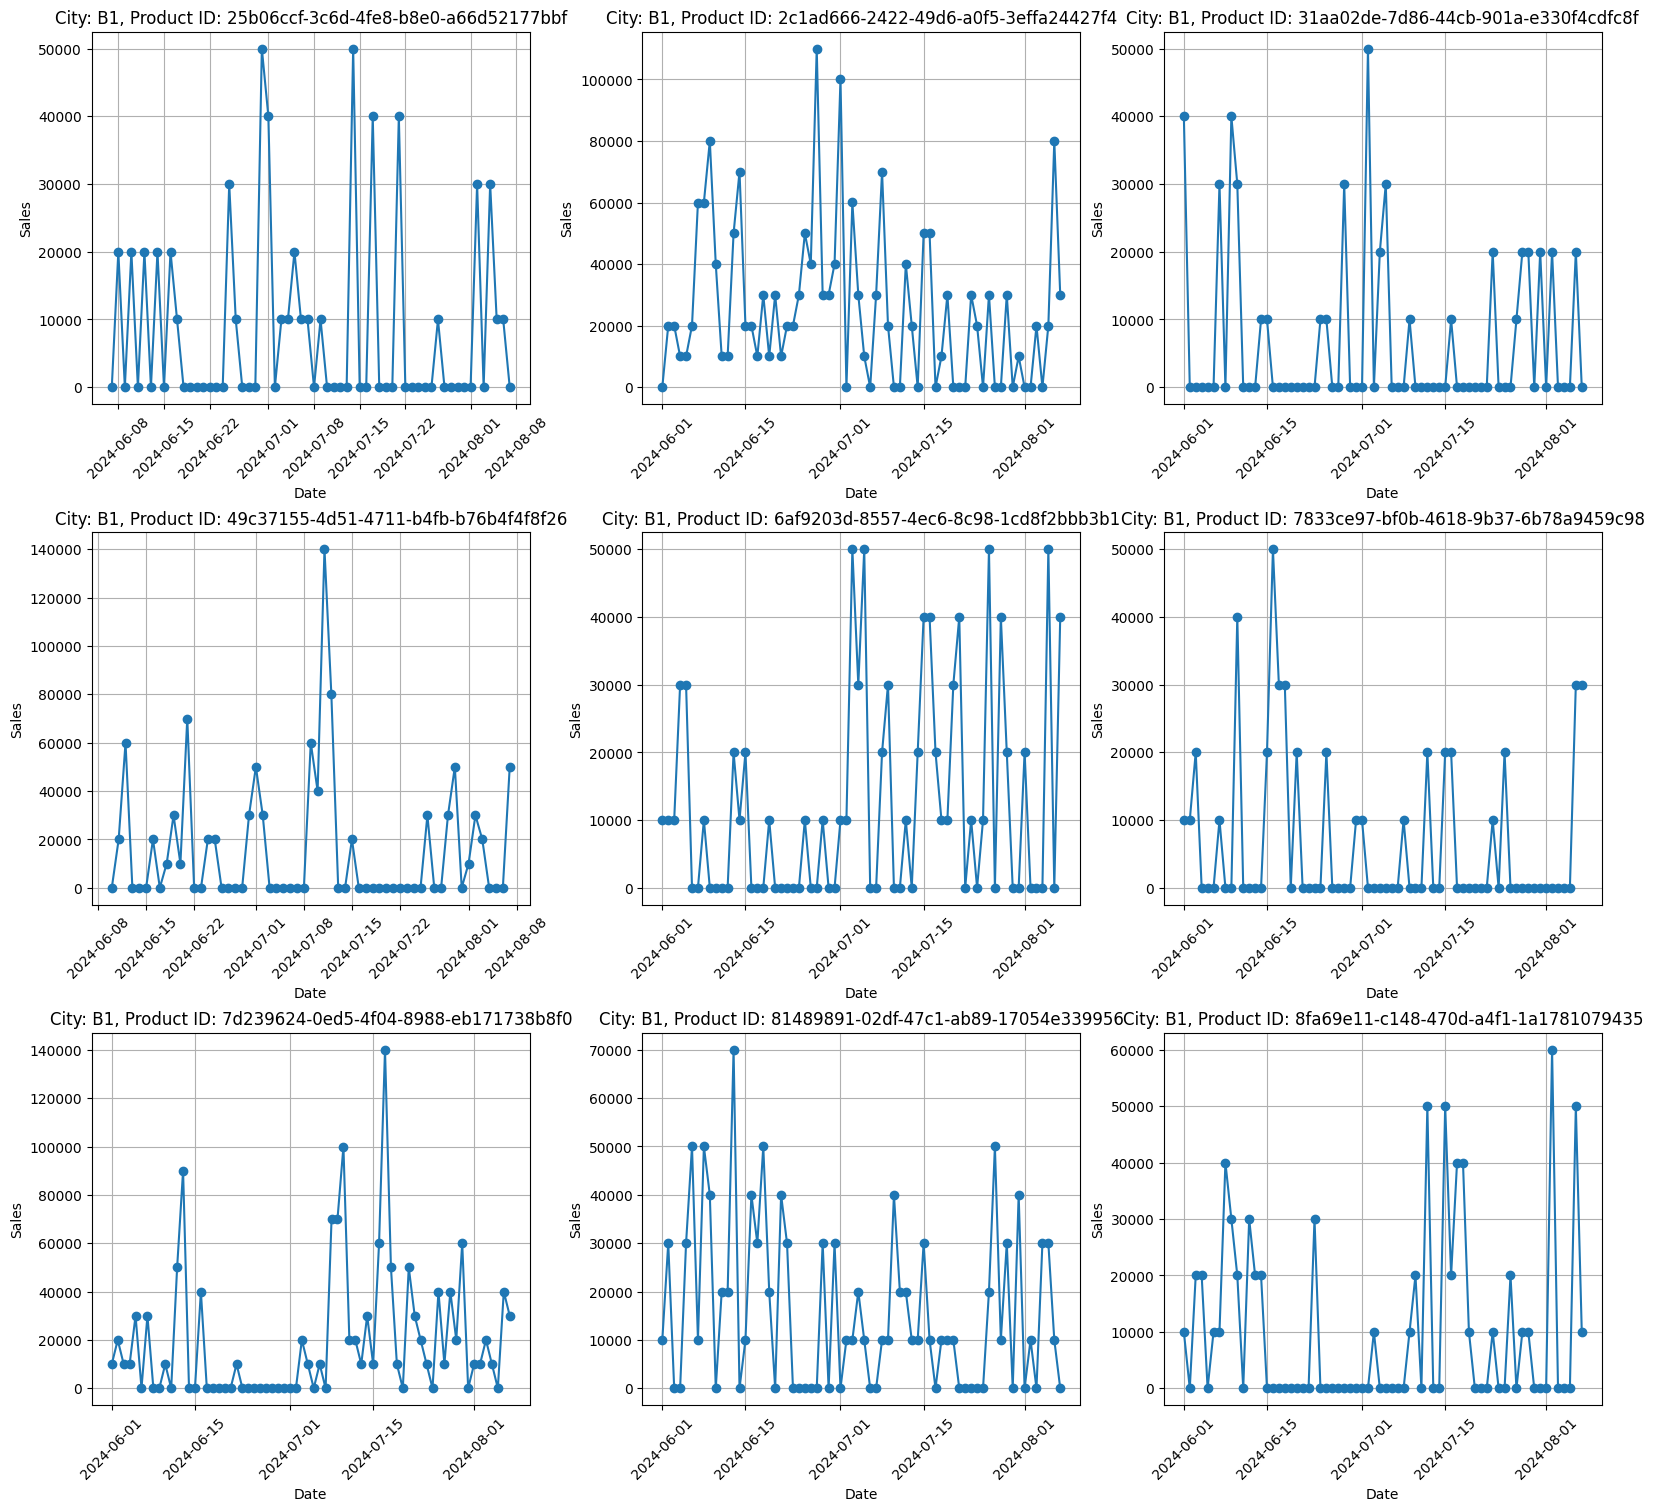

In [40]:
sample_size = 9
df_erratic = df[(df["class"] == "erratic") & (df["count"] >= 7)]
df_erratic_sample = pd.merge(
    df_erratic[["city", "product_id"]].drop_duplicates().iloc[0:9],
    df_erratic,
    how="inner",
    on=["city", "product_id"]
)

grouped = df_erratic_sample.groupby(["city", "product_id"])
plot_timeseries(grouped)

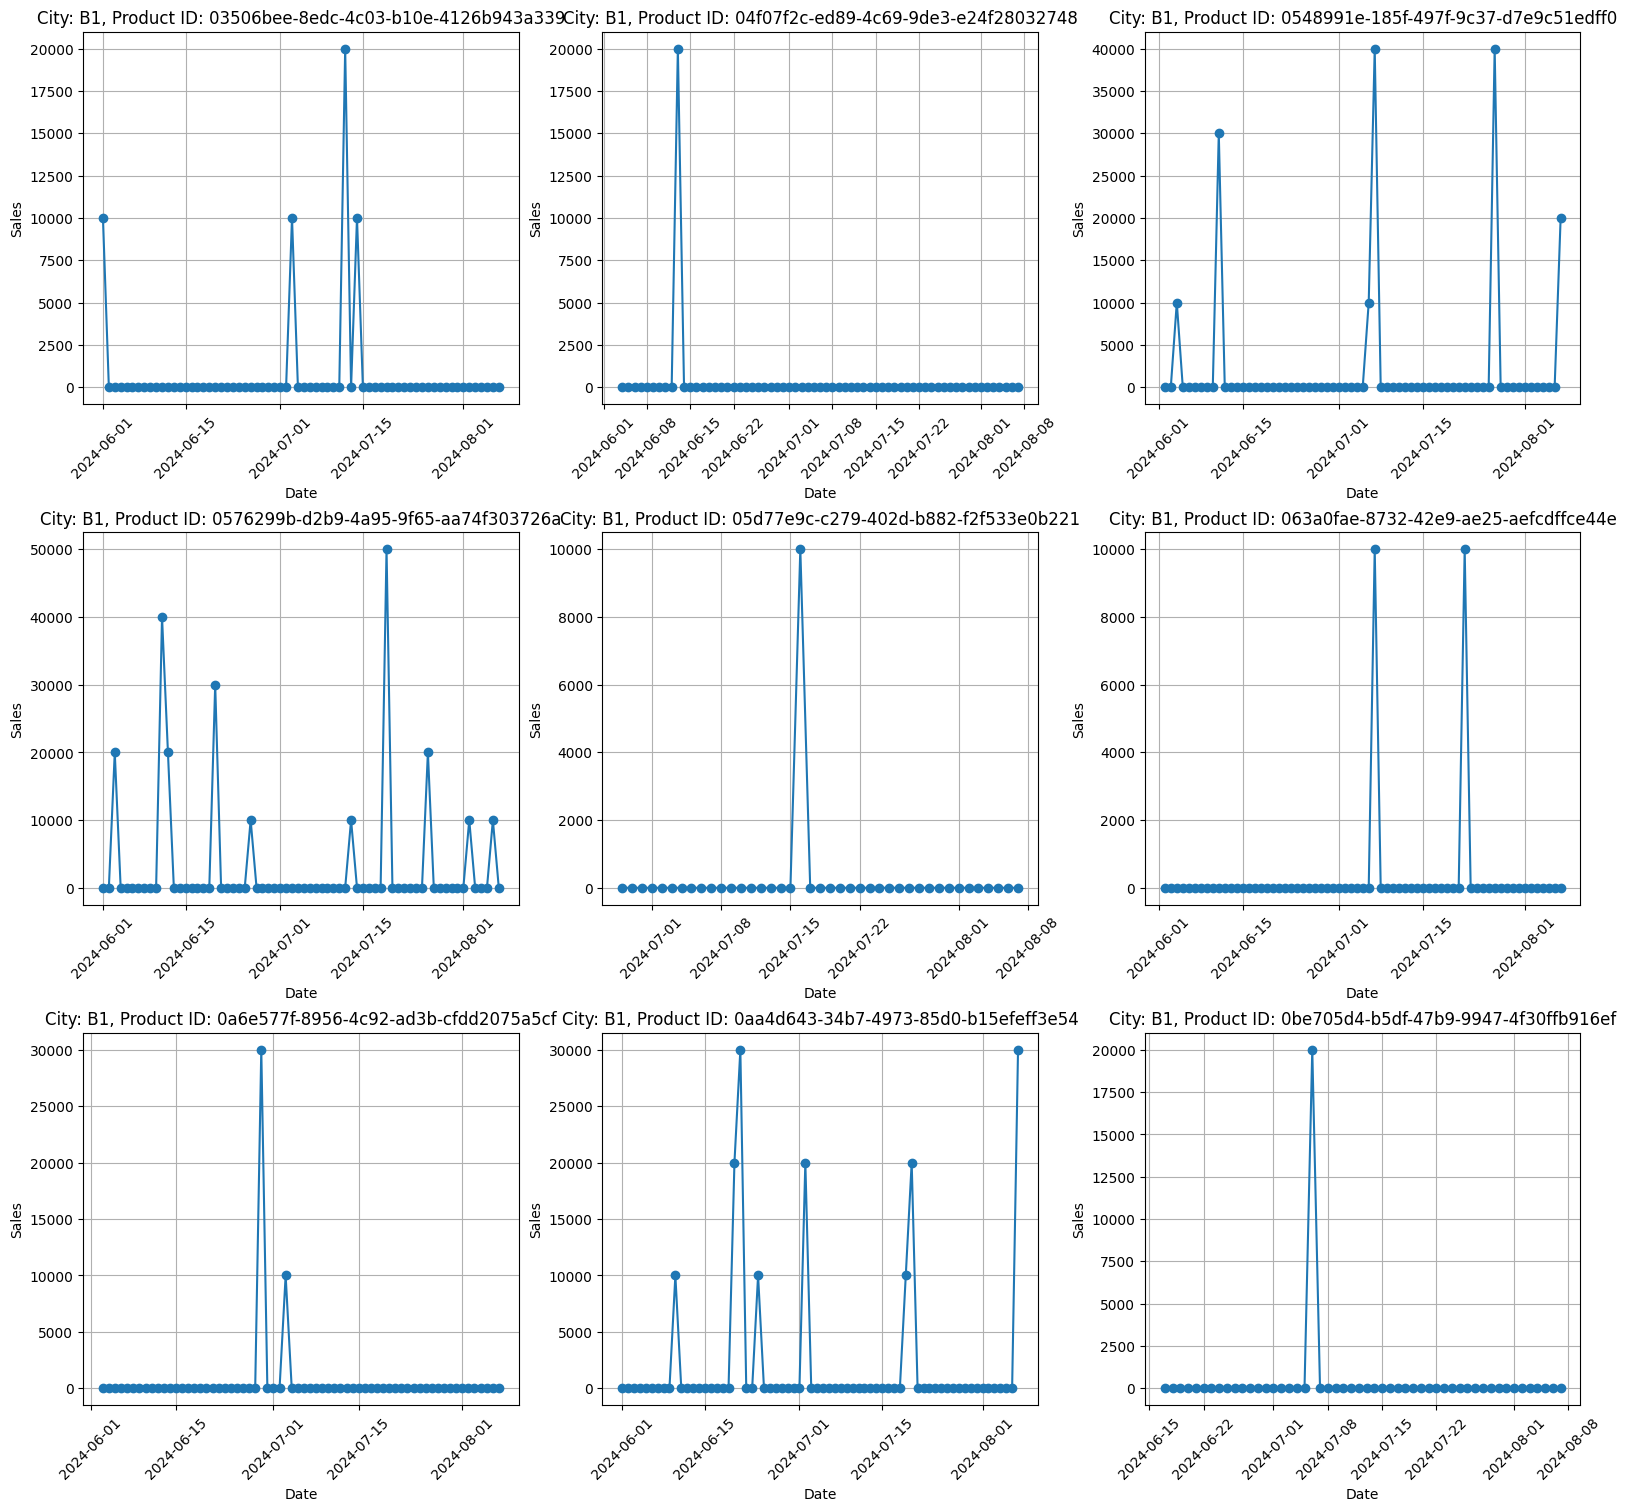

In [41]:
sample_size = 9
df_lumpy = df[(df["class"] == "lumpy") & (df["count"] >= 7)]
df_lumpy_sample = pd.merge(
    df_lumpy[["city", "product_id"]].drop_duplicates().iloc[0:9],
    df_lumpy,
    how="inner",
    on=["city", "product_id"]
)

grouped = df_lumpy_sample.groupby(["city", "product_id"])
plot_timeseries(grouped)